In [1]:
import scipy.io
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as patches
from matplotlib.path import Path
import operator 

# Image I/O
import skimage.io
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
import scipy.misc
import Image, ImageOps

# Image Filtering
import scipy.ndimage.filters
import scipy.stats as st
import scipy.signal
import scipy.ndimage

%matplotlib inline

# Utilities

In [2]:
# Display Images
def plot_1x2(img1, img2):
    fig = plt.figure(figsize = (20,10))
    ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')

In [3]:
# Convert RGB images to Grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
# Validate element to be evaluated
def isvalid(new_x, new_y, x, y, max_x, max_y):
    if new_x < 0 or new_x >= max_x:
        return False
    elif new_y < 0 or new_y >= max_y:
        return False
    elif new_x == x and new_y == y:
        return False
    else:
        return True

In [4]:
# Extract patch around given coordinate
def extract_patch(pt, img):
    patch = []
    x_slide = [-3,-2,-1,0,1,2,3]
    y_slide = [-3,-2,-1,0,1,2,3]
    img_x = int(pt[0])
    img_y = int(pt[1])
    
    # Assuming bounds are already validated
    for x in x_slide:
        tmp = []
        for y in y_slide:
            tmp.append(img[img_x+x, img_y+y])
        patch.append(tmp)
    return patch

In [5]:
# Plot corners on imgage
def draw_points(img, points):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    for elem in points:
        circ = Circle((elem[1], elem[0]),10)
        ax.add_patch(circ)
    plt.show()

In [6]:
# Concatenate images and draw lines between correct matches
def draw_lines(img1, img2, correct_matches):
    offset = img1.shape[1]
    stack_img = np.hstack((img1, img2))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.imshow(stack_img, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]
    
    for match in correct_matches:
        verts = [(match[0][1], match[0][0]), (match[1][1]+offset, match[1][0])]
        path = Path(verts, codes)
        ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()

In [7]:
def plot_correspondence(img1, img2, cor1, cor2):
    
    offset = img1.shape[0] - img2.shape[0]
    img_shift = img1.shape[1]
    top1 = 0
    top2 = 0
    if offset > 0:
        top2 = offset
    elif offset < 0:
        top1 = abs(offset)
    
    new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,1,0)
    new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,1,0)
    
    stack_img = np.hstack((new_img1, new_img2))

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.imshow(stack_img, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]

    for elem in cor1:
        circ = Circle((elem[0], elem[1]+top1),10)
        ax.add_patch(circ)

    for elem in cor2:
        circ = Circle((elem[0]+img_shift, elem[1]+top2),10)
        ax.add_patch(circ)
    
    codes = [Path.MOVETO,Path.LINETO]
    for elem1, elem2 in zip(cor1, cor2):
        verts = [(elem1[0], elem1[1]+top1), (elem2[0]+img_shift, elem2[1]+top2)]
        path = Path(verts, codes)
        ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()

# Load Data

In [8]:
dino_mat = scipy.io.loadmat('data/dino2.mat')
dino_01 = np.array(dino_mat['dino01'])
dino_02 = np.array(dino_mat['dino02'])
cor_01 = np.array(dino_mat['cor1'])
cor_02 = np.array(dino_mat['cor2'])

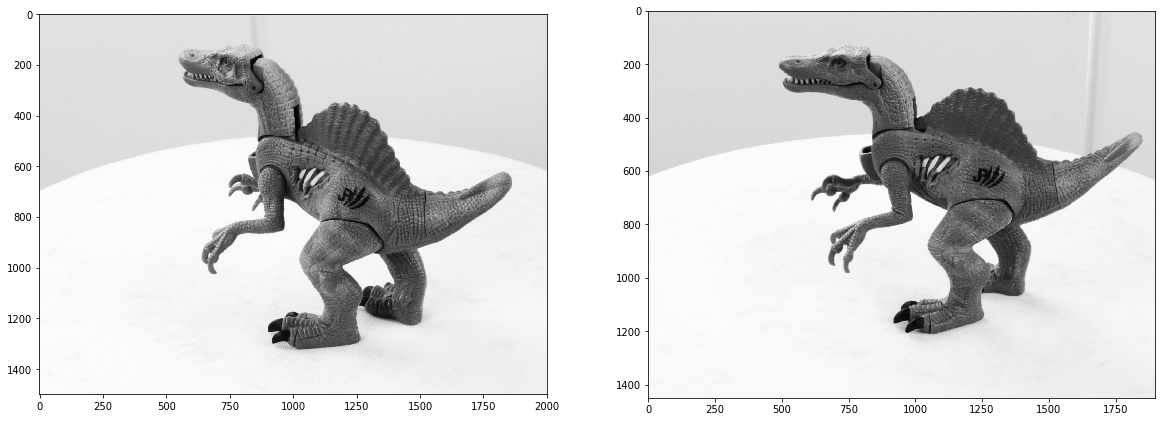

In [9]:
dino_01 = rgb2gray(dino_01)
dino_02 = rgb2gray(dino_02)
plot_1x2(dino_01, dino_02)

# Gaussian Filtering

In [10]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

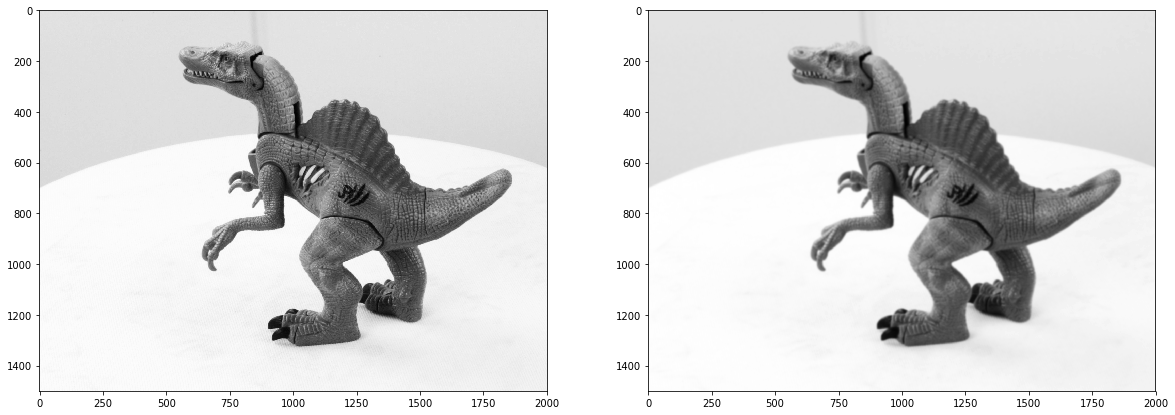

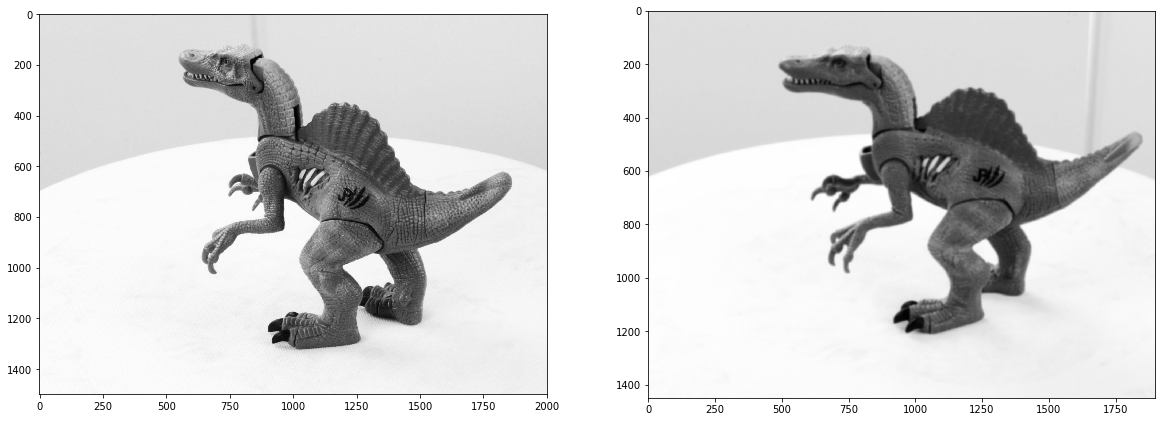

In [11]:
smooth_dino_01 = scipy.ndimage.filters.correlate(dino_01, gkern(21,5))
smooth_dino_02 = scipy.ndimage.filters.correlate(dino_02, gkern(21,5))
plot_1x2(dino_01, smooth_dino_01)
plot_1x2(dino_01, smooth_dino_02)

# Image Gradients

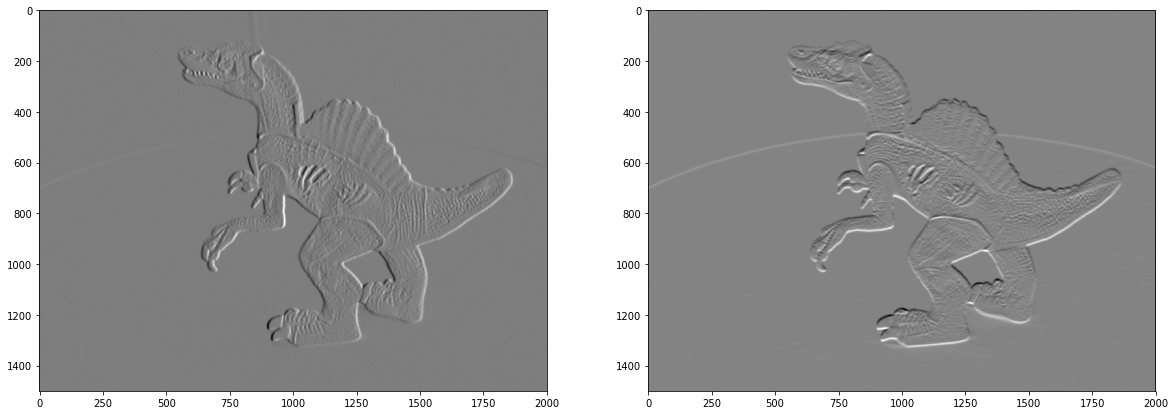

In [12]:
gradient_x = [[-1,0,1],[-1,0,1],[-1,0,1]] # gradient along x
graident_y = [[-1,-1,-1],[0,0,0],[1,1,1]] # gradient along y

I_x = scipy.ndimage.filters.correlate(smooth_dino_01, gradient_x)
I_y = scipy.ndimage.filters.correlate(smooth_dino_01, graident_y)
plot_1x2(I_x, I_y)

# Corner Detection

In [13]:
# Compute elements of C Matrix
I_x2 = np.multiply(I_x, I_x)
I_y2 = np.multiply(I_y, I_y)
I_xy = np.multiply(I_x, I_y)

In [ ]:
row, col = dino_01.shape
C_min = np.zeros((row,col))
C_max = np.zeros((row,col))

# Store minimum eigen values in  separate matrix 
for i in range(row):
    for j in range(col):
            C_min[i,j] = min(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]]))
            C_max[i,j] = max(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]]))

In [ ]:
x_slide = [-1,0,1]
y_slide = [-1,0,1]
corners = []
    
# For each pixel, choose the coordinate points of those that have 
# largest min eigen value among neighbors   
for i in range(row):
    for j in range(col):
        flag = True
        for x in x_slide:
            for y in y_slide:
                if isvalid(i+x, j+y, i, j, row, col):
                    if C_min[i,j] < C_min[i+x,j+y]:
                        flag = False
        if flag == True:
            corners.append((i,j,C_min[i,j]))                

In [22]:
# Sort detected corners based on corner score
corners.sort(key=operator.itemgetter(2), reverse=True)

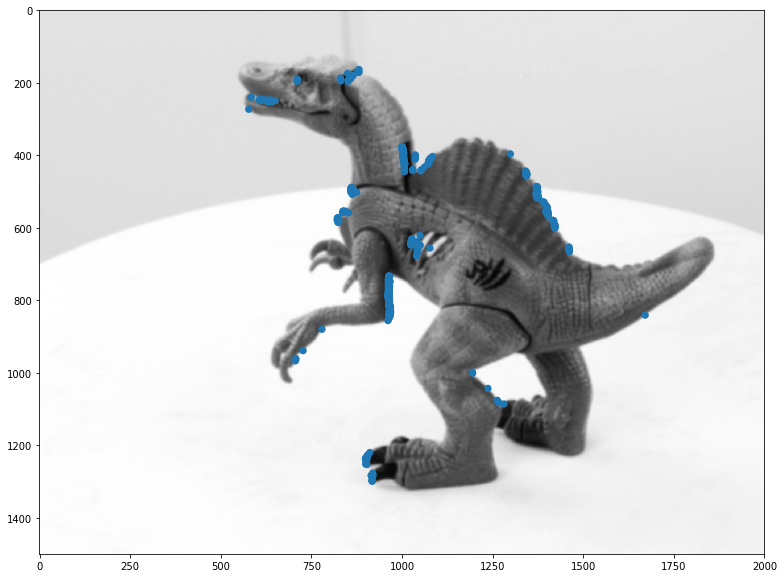

In [25]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(smooth_dino_01, cmap='gray')
count = 0

for elem in corners:
    circ = Circle((elem[1], elem[0]),10)
    ax.add_patch(circ)
    count += 1
    if count > 400:
        break
plt.show()